In [1]:
import anki_vector
import time
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
## Testing if the Robot config is setup

# with anki_vector.Robot() as robot:
#     robot.anim.play_animation_trigger("GreetAfterLongTime")

15:31:31.746               robot.Robot WARNING  No serial number or name provided. Automatically selecting 00603a88
15:31:31.750     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
15:31:32.633     connection.Connection    INFO  BehaviorControl control_granted_response { }


16:10:10.909               robot.Robot WARNING  No serial number or name provided. Automatically selecting 00603a88
16:10:10.911     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
16:10:11.392     connection.Connection    INFO  BehaviorControl control_granted_response { }


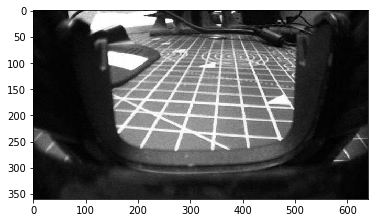

In [2]:
robot = anki_vector.Robot()
robot.connect()
robot.camera.init_camera_feed()
robot.motors.set_head_motor(-5.0) # move head to look at ground
time.sleep(1)
robot.motors.set_wheel_motors(10, 10) # set initial driving direction

imageFromVector = robot.camera.latest_image
image = cv2.cvtColor(np.array(imageFromVector.raw_image),cv2.COLOR_BGR2GRAY) #convert image to gray

plt.imshow(image,cmap="gray")
plt.show()
cv2.waitKey(3)


robot.disconnect()

In [23]:
robot.disconnect()